In [ ]:
#환경변수 설정
#keras,tensorflow 모두 최신버전 설치하면 됨

In [1]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report

Using TensorFlow backend.


In [2]:
#경로 설정
file_path = '../SmartFarm/SF'

In [4]:
name_class = os.listdir(file_path)
name_class

['Harvesting', 'Floral differentiation', 'Bloom']

In [5]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [6]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,../SmartFarm/SF/Floral differentiation/16_2020...,Floral differentiation
1,../SmartFarm/SF/Floral differentiation/16_2020...,Floral differentiation
2,../SmartFarm/SF/Floral differentiation/16_2020...,Floral differentiation
3,../SmartFarm/SF/Bloom/16_20201126_1423191.jpg,Bloom
4,../SmartFarm/SF/Floral differentiation/16_2020...,Floral differentiation


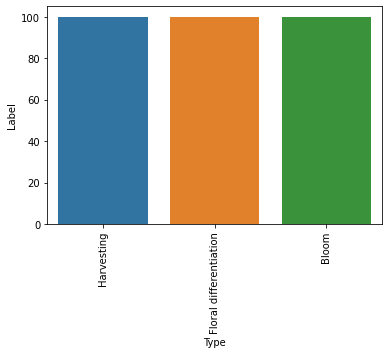

In [7]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [8]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

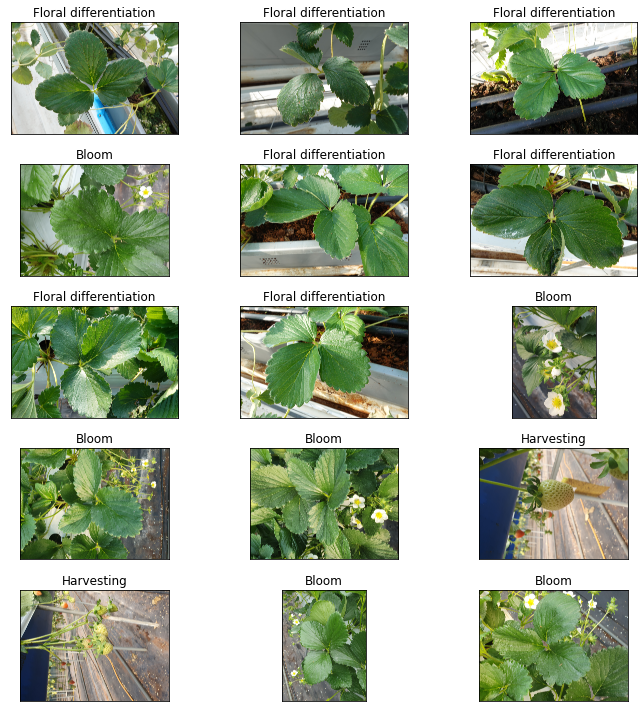

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,10), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [10]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  validation_split=0.4)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=5,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=5,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=5,
    shuffle=False
)

Found 225 validated image filenames belonging to 3 classes.
Found 225 validated image filenames belonging to 3 classes.
Found 75 validated image filenames belonging to 3 classes.


In [12]:
pretrained_model = ResNet50(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [13]:
inputs = pretrained_model.input

x = Dense(64, activation='relu')(pretrained_model.output)
x = Dense(64, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50
    #callbacks=my_callbacks
)

Epoch 1/50
45/45 [==============================] - 87s 2s/step - loss: 0.7626 - accuracy: 0.7511 - val_loss: 13593.6846 - val_accuracy: 0.3200
Epoch 2/50
45/45 [==============================] - 66s 1s/step - loss: 0.5757 - accuracy: 0.8311 - val_loss: 2.3260 - val_accuracy: 0.6578
Epoch 3/50
45/45 [==============================] - 67s 1s/step - loss: 0.4282 - accuracy: 0.8889 - val_loss: 22.6231 - val_accuracy: 0.3333
Epoch 4/50
45/45 [==============================] - 67s 1s/step - loss: 0.3590 - accuracy: 0.8889 - val_loss: 0.0682 - val_accuracy: 0.8178
Epoch 5/50
45/45 [==============================] - 67s 1s/step - loss: 0.1259 - accuracy: 0.9556 - val_loss: 4.1697 - val_accuracy: 0.7333
Epoch 6/50
45/45 [==============================] - 66s 1s/step - loss: 0.2303 - accuracy: 0.9289 - val_loss: 0.7731 - val_accuracy: 0.6133
Epoch 7/50
45/45 [==============================] - 67s 1s/step - loss: 0.1835 - accuracy: 0.9556 - val_loss: 4.7789 - val_accuracy: 0.4578
Epoch 8/50
45/4

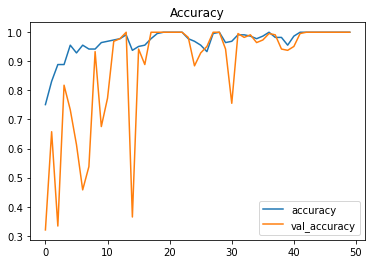

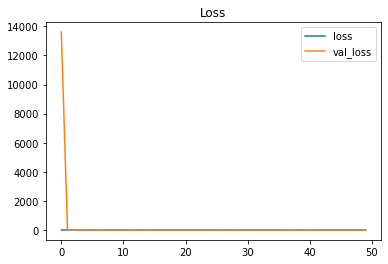

In [16]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [17]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00009
Test Accuracy: 100.00%


In [18]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [19]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                        precision    recall  f1-score   support

                 Bloom       1.00      1.00      1.00        23
Floral differentiation       1.00      1.00      1.00        28
            Harvesting       1.00      1.00      1.00        24

              accuracy                           1.00        75
             macro avg       1.00      1.00      1.00        75
          weighted avg       1.00      1.00      1.00        75



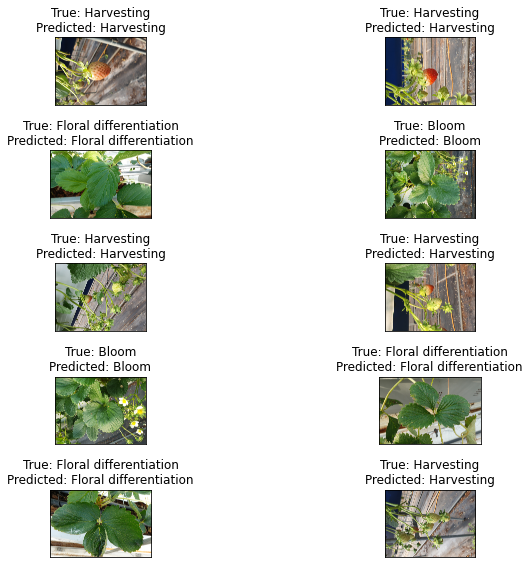

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()